In [ ]:
import os
import numpy as np
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [ ]:

!unzip "/content/drive/MyDrive/Major_project/PD_Data.zip" -d "/content/dataset"


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/PD_Data/Training_images/train_img_334.png  
  inflating: /content/dataset/PD_Data/Training_images/train_img_3340.png  
  inflating: /content/dataset/PD_Data/Training_images/train_img_3341.png  
  inflating: /content/dataset/PD_Data/Training_images/train_img_3342.png  
  inflating: /content/dataset/PD_Data/Training_images/train_img_3343.png  
  inflating: /content/dataset/PD_Data/Training_images/train_img_3344.png  
  inflating: /content/dataset/PD_Data/Training_images/train_img_3345.png  
  inflating: /content/dataset/PD_Data/Training_images/train_img_3346.png  
  inflating: /content/dataset/PD_Data/Training_images/train_img_3347.png  
  inflating: /content/dataset/PD_Data/Training_images/train_img_3348.png  
  inflating: /content/dataset/PD_Data/Training_images/train_img_3349.png  
  inflating: /content/dataset/PD_Data/Training_images/train_img_335.png  
  inflating: /content/dataset/PD_Data/Training_imag

In [ ]:

!unzip "/content/drive/MyDrive/November.zip" -d "/content/mul_dataset"


In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 150
PATCH_SIZE = 8                 # patch size on LL (128x128) -> 128/8 = 16 tokens per side
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_LAYERS = 6        # <- you asked for 6 encoders
MLP_UNITS = [128, 64]
LEARNING_RATE = 1e-4
#CHECKPOINT_PATH = "/content/drive/MyDrive/November/ATI_Vision_model_6_E_6_No_DWT_DTimes_raid_10_best_model_weights.h5"
CHECKPOINT_PATH = "/content/drive/MyDrive/November/VIT_CNN_weights/Copy of ATI_Vision_model_6_E_6_No_DWT_DTimes_raid_10_best_model_weights.h5"



In [ ]:
X_train = '/content/mul_dataset/radial_mask_10_mul_images/train'
X_test  = '/content/mul_dataset/radial_mask_10_mul_images/test'
X_val   = '/content/mul_dataset/radial_mask_10_mul_images/val'

X_train_gt = '/content/dataset/PD_Data/Training_images'
X_test_gt  = '/content/dataset/PD_Data/Test_images'
X_val_gt   = '/content/dataset/PD_Data/Valid_images'

In [ ]:
def conv_block(x, filters, name_prefix):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu", name=f"{name_prefix}_conv1")(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu", name=f"{name_prefix}_conv2")(x)
    return x

In [ ]:
def load_images(folder, size=(IMG_SIZE, IMG_SIZE)):
    imgs = []
    files = sorted([f for f in os.listdir(folder) if f.lower().endswith('.png')])
    for file in tqdm(files, desc=f"Loading {os.path.basename(folder)}", ncols=80):
        path = os.path.join(folder, file)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Skipped unreadable file: {file}")
            continue
        img = cv2.resize(img, size)
        imgs.append(img.astype(np.float32))
    return np.array(imgs, dtype=np.float32)

In [ ]:
class PatchEmbedding(layers.Layer):
    def __init__(self, patch_size, projection_dim):
        super().__init__()
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.proj = layers.Conv2D(projection_dim, patch_size, strides=patch_size, padding="valid")

    def call(self, x):
        x = self.proj(x)
        x = tf.reshape(x, [tf.shape(x)[0], -1, self.projection_dim])
        return x

In [ ]:
class TrainablePositionalEmbedding(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.pos_emb = self.add_weight(shape=(1, num_patches, projection_dim),
                                       initializer="random_normal",
                                       trainable=True,
                                       name="pos_embedding")
    def call(self, x):
        return x + self.pos_emb

In [ ]:
def transformer_block(inputs, projection_dim, num_heads, mlp_units, dropout=0.1):
    x1 = layers.LayerNormalization(epsilon=1e-6)(inputs)
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x1, x1)
    attn_output = layers.Dropout(dropout)(attn_output)
    x2 = layers.Add()([inputs, attn_output])
    y1 = layers.LayerNormalization(epsilon=1e-6)(x2)
    for units in mlp_units:
        y1 = layers.Dense(units, activation=tf.nn.gelu)(y1)
    y1 = layers.Dropout(dropout)(y1)
    return layers.Add()([x2, y1])

In [ ]:
def build_vit_denoiser(
    img_size=256,
    patch_size=8,
    projection_dim=256,
    num_heads=4,
    transformer_layers=4,
    mlp_units=[512, 256],
):
    inputs = Input(shape=(img_size, img_size, 1), name="input_image")

    #  Encoder (Using AveragePooling instead of MaxPooling)
    e1 = conv_block(inputs, 64, "enc1")                 # 256×256×64
    p1 = layers.AveragePooling2D((2, 2), name="pool1")(e1)  # 128×128×64

    e2 = conv_block(p1, 128, "enc2")                    # 128×128×128
    p2 = layers.AveragePooling2D((2, 2), name="pool2")(e2)  # 64×64×128

    e3 = conv_block(p2, 256, "enc3")                    # 64×64×256
    p3 = layers.AveragePooling2D((2, 2), name="pool3")(e3)  # 32×32×256

    # Transformer Bottleneck (ViT)
    static_shape = K.int_shape(p3)
    if static_shape[1] is not None:
        h, w = static_shape[1], static_shape[2]
        ph, pw = h // patch_size, w // patch_size
        num_patches = ph * pw
    else:
        shape = tf.shape(p3)
        h, w = shape[1], shape[2]
        ph, pw = h // patch_size, w // patch_size
        num_patches = ph * pw

    x = PatchEmbedding(patch_size, projection_dim)(p3)
    x = TrainablePositionalEmbedding(int(num_patches), projection_dim)(x)

    for _ in range(transformer_layers):
        x = transformer_block(x, projection_dim, num_heads, mlp_units)

    # Reshape Transformer tokens back to feature map
    if isinstance(ph, int) and isinstance(pw, int):
        x = layers.Reshape((ph, pw, projection_dim), name="reshape_bottleneck")(x)
    else:
        def dynamic_reshape(t):
            b = tf.shape(t)[0]
            return tf.reshape(t, (b, ph, pw, projection_dim))
        x = layers.Lambda(dynamic_reshape, name="reshape_bottleneck_dynamic")(x)

    # Upsample bottleneck to match encoder depth
    x = layers.Conv2DTranspose(256, 3, strides=2, padding="same", activation="relu", name="up_bottleneck1")(x)
    x = layers.Conv2DTranspose(256, 3, strides=2, padding="same", activation="relu", name="up_bottleneck2")(x)
    x = layers.Conv2DTranspose(256, 3, strides=2, padding="same", activation="relu", name="up_bottleneck3")(x)

    #  Decoder (Symmetric)
    def up_block(x, skip, filters, name):
        x = layers.Conv2DTranspose(filters, 3, strides=2, padding="same", activation="relu", name=f"{name}_up")(x)
        x = layers.Resizing(K.int_shape(skip)[1], K.int_shape(skip)[2], name=f"{name}_resize")(x)
        x = layers.Concatenate(axis=-1, name=f"{name}_concat")([x, skip])
        x = conv_block(x, filters, f"{name}_conv")
        return x

    d3 = up_block(x, e3, 256, "dec3")
    d2 = up_block(d3, e2, 128, "dec2")
    d1 = up_block(d2, e1, 64, "dec1")

    #  Final Reconstruction
    outputs = layers.Conv2D(1, 3, padding="same", activation="sigmoid", name="reconstruction")(d1)

    model = Model(inputs=inputs, outputs=outputs, name="Pure_ViT_Denoiser_AvgPool")
    return model

In [ ]:
vit_denoiser = build_vit_denoiser(
    img_size=IMG_SIZE,
    patch_size=PATCH_SIZE,
    projection_dim=PROJECTION_DIM,
    num_heads=NUM_HEADS,
    transformer_layers=TRANSFORMER_LAYERS,
    mlp_units=MLP_UNITS,
)

In [ ]:
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def combined_loss(y_true, y_pred):
    return 0.85 * tf.reduce_mean(tf.abs(y_true - y_pred)) + 0.15 * ssim_loss(y_true, y_pred)

def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)


In [ ]:
vit_denoiser.compile(
    optimizer=Adam(LEARNING_RATE),
    loss="mse",
    metrics=["mae",psnr_metric, ssim_metric, tf.keras.metrics.MeanSquaredError(name='mse')]
)

vit_denoiser.summary()

Model: "Pure_ViT_Denoiser_AvgPool"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv1 (Conv2D) │ (None, 256, 256,  │        640 │ input_image[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv2 (Conv2D) │ (None, 256, 256,  │     36,928 │ enc1_conv1[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 128, 128,  │          0 │ enc1_conv2[0][0]  │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_conv1 (Conv2D) │ (None, 128, 128,  │     73,856 │ pool1[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_conv2 (Conv2D) │ (None, 128, 128,  │    147,584 │ enc2_conv1[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 64, 64,    │          0 │ enc2_conv2[0][0]  │
│ (AveragePooling2D)  │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc3_conv1 (Conv2D) │ (None, 64, 64,    │    295,168 │ pool2[0][0]       │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc3_conv2 (Conv2D) │ (None, 64, 64,    │    590,080 │ enc3_conv1[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool3               │ (None, 32, 32,    │          0 │ enc3_conv2[0][0]  │
│ (AveragePooling2D)  │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embedding     │ (None, None, 64)  │  1,048,640 │ pool3[0][0]       │
│ (PatchEmbedding)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trainable_position… │ (None, 16, 64)    │      1,024 │ patch_embedding[… │
│ (TrainablePosition… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 16, 64)    │        128 │ trainable_positi… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 16, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16, 64)    │          0 │ trainable_positi… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 16, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 7,303,809 (27.86 MB)

 Trainable params: 7,303,809 (27.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

X_train_data = load_images(X_train)
X_test_data  = load_images(X_test)
X_val_data   = load_images(X_val)

X_train_gt_data = load_images(X_train_gt)
X_test_gt_data  = load_images(X_test_gt)
X_val_gt_data   = load_images(X_val_gt)

Loading Valid_images: 100%|██████████████████| 400/400 [00:00<00:00, 549.23it/s]


In [ ]:
X_train_data  = np.expand_dims(X_train_data / 255.0, axis=-1)
X_val_data    = np.expand_dims(X_val_data   / 255.0, axis=-1)
X_test_data   = np.expand_dims(X_test_data  / 255.0, axis=-1)

X_train_gt_data = np.expand_dims(X_train_gt_data / 255.0, axis=-1)
X_val_gt_data   = np.expand_dims(X_val_gt_data   / 255.0, axis=-1)
X_test_gt_data  = np.expand_dims(X_test_gt_data  / 255.0, axis=-1)

In [ ]:
print("Shapes:", X_train_data.shape, X_train_gt_data.shape, X_val_data.shape, X_test_data.shape)

train_ds = tf.data.Dataset.from_tensor_slices((X_train_data, X_train_gt_data)).shuffle(512).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val_data, X_val_gt_data)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test_data, X_test_gt_data)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Shapes: (3600, 256, 256, 1) (3600, 256, 256, 1) (400, 256, 256, 1) (400, 256, 256, 1)


In [ ]:
checkpoint = ModelCheckpoint(CHECKPOINT_PATH, save_best_only=True, monitor='val_loss', mode='min')
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
es = EarlyStopping(monitor='val_loss', patience=20, min_delta=0.01, restore_best_weights=True, verbose=1)


In [ ]:
history = vit_denoiser.fit(train_ds,
                      validation_data=val_ds,
                      epochs=EPOCHS,
                      callbacks=[checkpoint, reduce_lr, es],
                      verbose=1)


Epoch 1/150
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - loss: 0.0386 - mae: 0.1138 - mse: 0.0386 - psnr_metric: 18.7378 - ssim_metric: 0.5205

450/450 ━━━━━━━━━━━━━━━━━━━━ 275s 418ms/step - loss: 0.0385 - mae: 0.1136 - mse: 0.0385 - psnr_metric: 18.7464 - ssim_metric: 0.5208 - val_loss: 0.0030 - val_mae: 0.0287 - val_mse: 0.0030 - val_psnr_metric: 25.2735 - val_ssim_metric: 0.7499 - learning_rate: 1.0000e-04
Epoch 2/150
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - loss: 0.0027 - mae: 0.0272 - mse: 0.0027 - psnr_metric: 25.7121 - ssim_metric: 0.7584

450/450 ━━━━━━━━━━━━━━━━━━━━ 182s 405ms/step - loss: 0.0027 - mae: 0.0272 - mse: 0.0027 - psnr_metric: 25.7128 - ssim_metric: 0.7584 - val_loss: 0.0021 - val_mae: 0.0239 - val_mse: 0.0021 - val_psnr_metric: 26.7733 - val_ssim_metric: 0.7694 - learning_rate: 1.0000e-04
Epoch 3/150
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - loss: 0.0021 - mae: 0.0241 - mse: 0.0021 - psnr_metric: 26.8148 - ssim_metric: 0.7771

450/450 ━━━━━━━━━━━━━━━━━━━━ 182s 405ms/step - loss: 0.0021 - mae: 0.0241 - mse: 0.0021 - psnr_metric: 26.8151 - ssim_metric: 0.7771 - val_loss: 0.0019 - val_mae: 0.0225 - val_mse: 0.0019 - val_psnr_metric: 27.3706 - val_ssim_metric: 0.7803 - learning_rate: 1.0000e-04
Epoch 4/150
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - loss: 0.0019 - mae: 0.0227 - mse: 0.0019 - psnr_metric: 27.4103 - ssim_metric: 0.7865

450/450 ━━━━━━━━━━━━━━━━━━━━ 184s 408ms/step - loss: 0.0019 - mae: 0.0227 - mse: 0.0019 - psnr_metric: 27.4104 - ssim_metric: 0.7865 - val_loss: 0.0017 - val_mae: 0.0213 - val_mse: 0.0017 - val_psnr_metric: 27.8725 - val_ssim_metric: 0.7882 - learning_rate: 1.0000e-04
Epoch 5/150
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - loss: 0.0017 - mae: 0.0218 - mse: 0.0017 - psnr_metric: 27.7883 - ssim_metric: 0.7917

450/450 ━━━━━━━━━━━━━━━━━━━━ 183s 406ms/step - loss: 0.0017 - mae: 0.0218 - mse: 0.0017 - psnr_metric: 27.7884 - ssim_metric: 0.7917 - val_loss: 0.0016 - val_mae: 0.0207 - val_mse: 0.0016 - val_psnr_metric: 28.1405 - val_ssim_metric: 0.7939 - learning_rate: 1.0000e-04
Epoch 6/150
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - loss: 0.0016 - mae: 0.0211 - mse: 0.0016 - psnr_metric: 28.0932 - ssim_metric: 0.7981

450/450 ━━━━━━━━━━━━━━━━━━━━ 183s 405ms/step - loss: 0.0016 - mae: 0.0211 - mse: 0.0016 - psnr_metric: 28.0933 - ssim_metric: 0.7981 - val_loss: 0.0015 - val_mae: 0.0203 - val_mse: 0.0015 - val_psnr_metric: 28.3696 - val_ssim_metric: 0.7995 - learning_rate: 1.0000e-04
Epoch 7/150
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - loss: 0.0015 - mae: 0.0205 - mse: 0.0015 - psnr_metric: 28.3559 - ssim_metric: 0.8027

450/450 ━━━━━━━━━━━━━━━━━━━━ 182s 405ms/step - loss: 0.0015 - mae: 0.0205 - mse: 0.0015 - psnr_metric: 28.3559 - ssim_metric: 0.8027 - val_loss: 0.0014 - val_mae: 0.0198 - val_mse: 0.0014 - val_psnr_metric: 28.5393 - val_ssim_metric: 0.8021 - learning_rate: 1.0000e-04
Epoch 8/150
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - loss: 0.0014 - mae: 0.0200 - mse: 0.0014 - psnr_metric: 28.5493 - ssim_metric: 0.8071

450/450 ━━━━━━━━━━━━━━━━━━━━ 182s 405ms/step - loss: 0.0014 - mae: 0.0200 - mse: 0.0014 - psnr_metric: 28.5494 - ssim_metric: 0.8071 - val_loss: 0.0014 - val_mae: 0.0196 - val_mse: 0.0014 - val_psnr_metric: 28.6821 - val_ssim_metric: 0.8066 - learning_rate: 1.0000e-04
Epoch 9/150
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - loss: 0.0014 - mae: 0.0196 - mse: 0.0014 - psnr_metric: 28.7430 - ssim_metric: 0.8110

450/450 ━━━━━━━━━━━━━━━━━━━━ 182s 405ms/step - loss: 0.0014 - mae: 0.0196 - mse: 0.0014 - psnr_metric: 28.7430 - ssim_metric: 0.8110 - val_loss: 0.0013 - val_mae: 0.0192 - val_mse: 0.0013 - val_psnr_metric: 28.8544 - val_ssim_metric: 0.8078 - learning_rate: 1.0000e-04
Epoch 10/150
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - loss: 0.0013 - mae: 0.0192 - mse: 0.0013 - psnr_metric: 28.9040 - ssim_metric: 0.8135

450/450 ━━━━━━━━━━━━━━━━━━━━ 183s 406ms/step - loss: 0.0013 - mae: 0.0192 - mse: 0.0013 - psnr_metric: 28.9040 - ssim_metric: 0.8135 - val_loss: 0.0013 - val_mae: 0.0190 - val_mse: 0.0013 - val_psnr_metric: 28.9804 - val_ssim_metric: 0.8114 - learning_rate: 1.0000e-04
Epoch 11/150
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - loss: 0.0013 - mae: 0.0189 - mse: 0.0013 - psnr_metric: 29.0452 - ssim_metric: 0.8164

450/450 ━━━━━━━━━━━━━━━━━━━━ 183s 406ms/step - loss: 0.0013 - mae: 0.0189 - mse: 0.0013 - psnr_metric: 29.0452 - ssim_metric: 0.8164 - val_loss: 0.0013 - val_mae: 0.0188 - val_mse: 0.0013 - val_psnr_metric: 29.0625 - val_ssim_metric: 0.8132 - learning_rate: 1.0000e-04
Epoch 12/150
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - loss: 0.0012 - mae: 0.0187 - mse: 0.0012 - psnr_metric: 29.1826 - ssim_metric: 0.8187

450/450 ━━━━━━━━━━━━━━━━━━━━ 183s 407ms/step - loss: 0.0012 - mae: 0.0187 - mse: 0.0012 - psnr_metric: 29.1826 - ssim_metric: 0.8187 - val_loss: 0.0013 - val_mae: 0.0186 - val_mse: 0.0013 - val_psnr_metric: 29.1095 - val_ssim_metric: 0.8141 - learning_rate: 1.0000e-04
Epoch 13/150
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - loss: 0.0012 - mae: 0.0184 - mse: 0.0012 - psnr_metric: 29.3246 - ssim_metric: 0.8214

450/450 ━━━━━━━━━━━━━━━━━━━━ 183s 406ms/step - loss: 0.0012 - mae: 0.0184 - mse: 0.0012 - psnr_metric: 29.3246 - ssim_metric: 0.8214 - val_loss: 0.0012 - val_mae: 0.0184 - val_mse: 0.0012 - val_psnr_metric: 29.2367 - val_ssim_metric: 0.8174 - learning_rate: 1.0000e-04
Epoch 14/150
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - loss: 0.0012 - mae: 0.0181 - mse: 0.0012 - psnr_metric: 29.4351 - ssim_metric: 0.8239

450/450 ━━━━━━━━━━━━━━━━━━━━ 183s 407ms/step - loss: 0.0012 - mae: 0.0181 - mse: 0.0012 - psnr_metric: 29.4351 - ssim_metric: 0.8239 - val_loss: 0.0012 - val_mae: 0.0183 - val_mse: 0.0012 - val_psnr_metric: 29.2734 - val_ssim_metric: 0.8184 - learning_rate: 1.0000e-04
Epoch 15/150
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - loss: 0.0011 - mae: 0.0179 - mse: 0.0011 - psnr_metric: 29.5551 - ssim_metric: 0.8271

450/450 ━━━━━━━━━━━━━━━━━━━━ 183s 407ms/step - loss: 0.0011 - mae: 0.0179 - mse: 0.0011 - psnr_metric: 29.5551 - ssim_metric: 0.8271 - val_loss: 0.0012 - val_mae: 0.0181 - val_mse: 0.0012 - val_psnr_metric: 29.3606 - val_ssim_metric: 0.8249 - learning_rate: 1.0000e-04
Epoch 16/150
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - loss: 0.0011 - mae: 0.0176 - mse: 0.0011 - psnr_metric: 29.6805 - ssim_metric: 0.8412

450/450 ━━━━━━━━━━━━━━━━━━━━ 183s 407ms/step - loss: 0.0011 - mae: 0.0176 - mse: 0.0011 - psnr_metric: 29.6805 - ssim_metric: 0.8412 - val_loss: 0.0012 - val_mae: 0.0181 - val_mse: 0.0012 - val_psnr_metric: 29.4325 - val_ssim_metric: 0.8447 - learning_rate: 1.0000e-04
Epoch 17/150
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - loss: 0.0011 - mae: 0.0175 - mse: 0.0011 - psnr_metric: 29.8006 - ssim_metric: 0.8532

450/450 ━━━━━━━━━━━━━━━━━━━━ 183s 407ms/step - loss: 0.0011 - mae: 0.0175 - mse: 0.0011 - psnr_metric: 29.8006 - ssim_metric: 0.8532 - val_loss: 0.0012 - val_mae: 0.0179 - val_mse: 0.0012 - val_psnr_metric: 29.4699 - val_ssim_metric: 0.8499 - learning_rate: 1.0000e-04
Epoch 18/150
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - loss: 0.0011 - mae: 0.0173 - mse: 0.0011 - psnr_metric: 29.9049 - ssim_metric: 0.8571

450/450 ━━━━━━━━━━━━━━━━━━━━ 183s 407ms/step - loss: 0.0011 - mae: 0.0173 - mse: 0.0011 - psnr_metric: 29.9049 - ssim_metric: 0.8571 - val_loss: 0.0012 - val_mae: 0.0179 - val_mse: 0.0012 - val_psnr_metric: 29.4718 - val_ssim_metric: 0.8517 - learning_rate: 1.0000e-04
Epoch 19/150
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - loss: 0.0010 - mae: 0.0171 - mse: 0.0010 - psnr_metric: 29.9988 - ssim_metric: 0.8596

450/450 ━━━━━━━━━━━━━━━━━━━━ 183s 407ms/step - loss: 0.0010 - mae: 0.0171 - mse: 0.0010 - psnr_metric: 29.9988 - ssim_metric: 0.8596 - val_loss: 0.0012 - val_mae: 0.0180 - val_mse: 0.0012 - val_psnr_metric: 29.5318 - val_ssim_metric: 0.8479 - learning_rate: 1.0000e-04
Epoch 20/150
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - loss: 0.0010 - mae: 0.0169 - mse: 0.0010 - psnr_metric: 30.1001 - ssim_metric: 0.8616

450/450 ━━━━━━━━━━━━━━━━━━━━ 183s 407ms/step - loss: 0.0010 - mae: 0.0169 - mse: 0.0010 - psnr_metric: 30.1001 - ssim_metric: 0.8616 - val_loss: 0.0012 - val_mae: 0.0178 - val_mse: 0.0012 - val_psnr_metric: 29.5469 - val_ssim_metric: 0.8538 - learning_rate: 1.0000e-04
Epoch 21/150
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - loss: 9.8314e-04 - mae: 0.0167 - mse: 9.8314e-04 - psnr_metric: 30.2050 - ssim_metric: 0.8642


Epoch 21: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
450/450 ━━━━━━━━━━━━━━━━━━━━ 183s 406ms/step - loss: 9.8314e-04 - mae: 0.0167 - mse: 9.8314e-04 - psnr_metric: 30.2050 - ssim_metric: 0.8642 - val_loss: 0.0012 - val_mae: 0.0178 - val_mse: 0.0012 - val_psnr_metric: 29.5630 - val_ssim_metric: 0.8529 - learning_rate: 1.0000e-04
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 1.


In [ ]:
vit_denoiser.load_weights(CHECKPOINT_PATH)
y_pred = vit_denoiser.predict(X_test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step


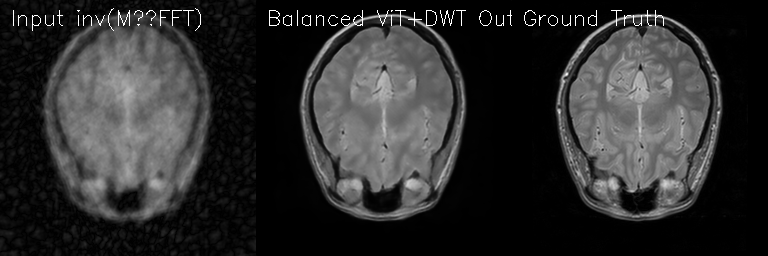

In [ ]:

idx = 10
masked_img = (X_test_data[idx] * 255).astype(np.uint8)
pred_img   = np.clip(y_pred[idx] * 255, 0, 255).astype(np.uint8)
gt_img     = (X_test_gt_data[idx] * 255).astype(np.uint8)

masked_disp = cv2.cvtColor(masked_img, cv2.COLOR_GRAY2BGR)
pred_disp   = cv2.cvtColor(pred_img,   cv2.COLOR_GRAY2BGR)
gt_disp     = cv2.cvtColor(gt_img,     cv2.COLOR_GRAY2BGR)
#cv2.putText(masked_disp, 'Input inv(M×FFT)', (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 1)
#cv2.putText(pred_disp,   'Balanced ViT+DWT Output', (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 1)
#cv2.putText(gt_disp,     'Ground Truth', (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 1)

combined = np.hstack((masked_disp, pred_disp, gt_disp))
cv2_imshow(combined)


In [ ]:
mae_list, mse_list, psnr_list, ssim_list = [], [], [], []
for i in range(len(X_test_data)):
    y_true = X_test_gt_data[i]
    y_pred_i = y_pred[i]
    mae_list.append(np.mean(np.abs(y_true - y_pred_i)))
    mse_list.append(np.mean((y_true - y_pred_i) ** 2))
    psnr_list.append(tf.image.psnr(y_true, y_pred_i, max_val=1.0).numpy())
    ssim_list.append(tf.image.ssim(y_true, y_pred_i, max_val=1.0).numpy())

print("\n=== Balanced ViT+DWT Denoiser Evaluation ===")
print(f"MAE  : {np.mean(mae_list):.6f}")
print(f"MSE  : {np.mean(mse_list):.6f}")
print(f"PSNR : {np.mean(psnr_list):.2f} dB")
print(f"SSIM : {np.mean(ssim_list):.4f}")


=== Balanced ViT+DWT Denoiser Evaluation ===
MAE  : 0.017837
MSE  : 0.001143
PSNR : 29.61 dB
SSIM : 0.8543
